In [ ]:
import os, time, json, math, random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# configuration (adjust as needed)
DATA_ROOT = "data/tiles"          
IMG_SIZE = 224
BATCH_SIZE = 16 # change this according to the vram avaliability
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
EPOCHS = 35
LR = 0.0018
WEIGHT_DECAY = 1e-4
SEED = 42
LABEL_SMOOTHING = 0.05
CHANNELS = (32, 64, 128, 256)
FEATURE_DROPOUT = 0.15
CLASSIFIER_DROPOUT = 0.25
WARMUP_EPOCHS = 3
EARLY_STOP_PATIENCE = 7
USE_AMP = True                  

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


In [2]:
def set_seed(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    import numpy as np
    np.random.seed(seed)

set_seed(SEED)

In [3]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def make_transforms(img_size: int):
    train_tfms = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(0.25, 0.25, 0.25, 0.15),
        transforms.RandomRotation(25),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
    eval_tfms = transforms.Compose([
        transforms.Resize(int(img_size * 1.15)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
    return train_tfms, eval_tfms

In [ ]:
def stratified_split(targets, val_split, test_split, seed):
    indices = list(range(len(targets)))
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=test_split, random_state=seed)
    tv_idx, test_idx = next(sss1.split(indices, [targets[i] for i in indices]))
    tv_indices = [indices[i] for i in tv_idx]
    test_indices = [indices[i] for i in test_idx]
    y_tv = [targets[i] for i in tv_indices]
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_split/(1 - test_split), random_state=seed)
    train_rel, val_rel = next(sss2.split(tv_indices, y_tv))
    train_indices = [tv_indices[i] for i in train_rel]
    val_indices = [tv_indices[i] for i in val_rel]
    return train_indices, val_indices, test_indices

train_tfms, eval_tfms = make_transforms(IMG_SIZE)

# base dataset to obtain labels
base_dataset = datasets.ImageFolder(DATA_ROOT)
targets = [s[1] for s in base_dataset.samples]

train_idx, val_idx, test_idx = stratified_split(targets, VAL_SPLIT, TEST_SPLIT, SEED)

train_ds = datasets.ImageFolder(DATA_ROOT, transform=train_tfms)
val_ds   = datasets.ImageFolder(DATA_ROOT, transform=eval_tfms)
test_ds  = datasets.ImageFolder(DATA_ROOT, transform=eval_tfms)

train_loader = DataLoader(Subset(train_ds, train_idx), batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(Subset(val_ds,   val_idx),   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(Subset(test_ds,  test_idx),  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

class_to_idx = train_ds.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Classes:", class_to_idx)
print("Train/Val/Test sizes:", len(train_idx), len(val_idx), len(test_idx))

Classes: {'NoTrees': 0, 'Trees': 1}
Train/Val/Test sizes: 7280 1560 1560


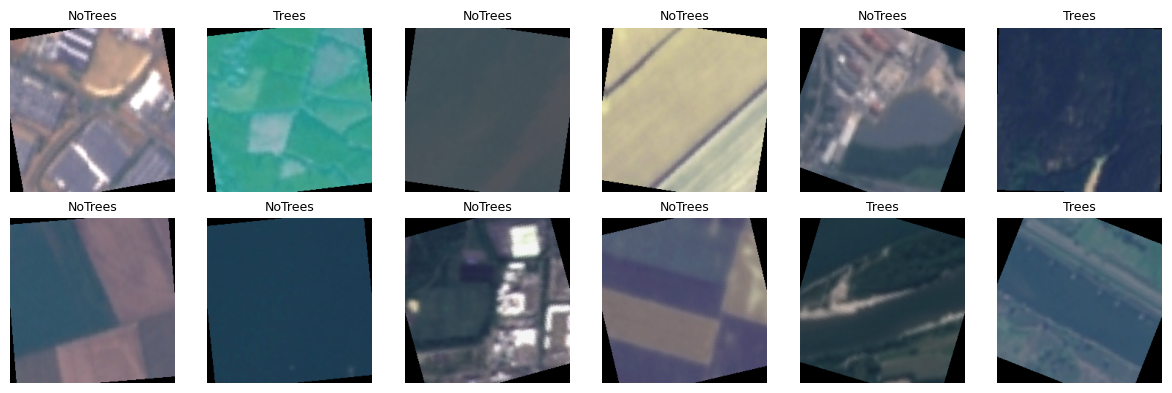

In [ ]:
batch_imgs, batch_labels = next(iter(train_loader))

inv_norm = transforms.Normalize(
    mean=[-m/s for m, s in zip(IMAGENET_MEAN, IMAGENET_STD)],
    std=[1/s for s in IMAGENET_STD]
)

def show_batch(images, labels, n=12):
    n = min(n, images.size(0))
    cols = 6
    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(n):
        ax = plt.subplot(rows, cols, i+1)
        img = inv_norm(images[i]).permute(1,2,0).clamp(0,1).cpu().numpy()
        ax.imshow(img)
        ax.set_title(idx_to_class[labels[i].item()], fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_batch(batch_imgs, batch_labels, n=12)

In [9]:
def conv_block(in_ch, out_ch, k=3, p=1, dropout=0.0):
    layers = [
        nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
    ]
    if dropout > 0:
        layers.append(nn.Dropout(dropout))
    return nn.Sequential(*layers)

class DeforNet(nn.Module):
    def __init__(self, num_classes, in_channels=3, channels=(32,64,128,256),
                 feature_dropout=0.15, classifier_dropout=0.25):
        super().__init__()
        blocks = []
        prev = in_channels
        for ch in channels:
            blocks.append(conv_block(prev, ch, dropout=feature_dropout))
            blocks.append(conv_block(ch, ch, dropout=feature_dropout))
            blocks.append(nn.MaxPool2d(2))
            prev = ch
        self.features = nn.Sequential(*blocks)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(classifier_dropout),
            nn.Linear(channels[-1], num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

model = DeforNet(
    num_classes=len(class_to_idx),
    channels=CHANNELS,
    feature_dropout=FEATURE_DROPOUT,
    classifier_dropout=CLASSIFIER_DROPOUT
).to(DEVICE)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {params/1e6:.2f}M")
model

Model parameters: 1.17M


DeforNet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.15, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.15, inplace=False)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.15, inplace=False)
    )
    (4): Sequential(
      (0): Conv2d(64, 6

In [ ]:
def label_smoothing_ce(logits, targets, smoothing, num_classes):
    import torch.nn.functional as F
    if smoothing <= 0:
        return F.cross_entropy(logits, targets)
    with torch.no_grad():
        dist = torch.zeros_like(logits)
        dist.fill_(smoothing / (num_classes - 1))
        dist.scatter_(1, targets.unsqueeze(1), 1 - smoothing)
    log_probs = torch.log_softmax(logits, dim=1)
    return -(dist * log_probs).sum(dim=1).mean()

In [11]:
import numpy as np

class WarmupCosineScheduler:
    def __init__(self, optimizer, warmup_epochs, total_epochs, min_lr=1e-6):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.min_lr = min_lr
        self.base_lrs = [pg["lr"] for pg in optimizer.param_groups]

    def step(self, epoch):
        if epoch < self.warmup_epochs:
            frac = (epoch + 1) / self.warmup_epochs
            for pg, base in zip(self.optimizer.param_groups, self.base_lrs):
                pg["lr"] = base * frac
        else:
            t = (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            cos = 0.5 * (1 + np.cos(np.pi * t))
            for pg, base in zip(self.optimizer.param_groups, self.base_lrs):
                pg["lr"] = self.min_lr + (base - self.min_lr) * cos

In [14]:
def train_epoch(model, loader, optimizer, scaler, device, num_classes, smoothing):
    model.train()
    total_loss, correct, total_samples = 0.0, 0, 0
    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            logits = model(imgs)
            loss = label_smoothing_ce(logits, labels, smoothing, num_classes)
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)
    return total_loss / total_samples, correct / total_samples

@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    total_loss, correct, total_samples = 0.0, 0, 0
    all_labels, all_preds = [], []
    for imgs, labels in tqdm(loader, desc="Eval", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = F.cross_entropy(logits, labels)
        total_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)
        all_labels.extend(labels.cpu().tolist())
        all_preds.extend(preds.cpu().tolist())
    return total_loss / total_samples, correct / total_samples, all_labels, all_preds

In [15]:
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    scheduler.step(epoch)

    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, scaler,
                                  DEVICE, len(class_to_idx), LABEL_SMOOTHING)
    val_loss, val_acc, val_labels, val_preds = eval_epoch(model, val_loader, DEVICE)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Train loss {tr_loss:.4f} acc {tr_acc:.4f}")
    print(f"Val   loss {val_loss:.4f} acc {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_state = {
            "state_dict": model.state_dict(),
            "class_to_idx": class_to_idx,
            "img_size": IMG_SIZE,
            "channels": CHANNELS
        }
        print("Saved new best model (in memory).")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print("Early stopping triggered.")
            break


Epoch 1/35


Train:   0%|          | 0/455 [00:00<?, ?it/s]C:\Users\shaik\AppData\Local\Temp\ipykernel_27380\1855457722.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Train loss 0.5898 acc 0.7312
Val   loss 0.5611 acc 0.7519
Saved new best model (in memory).

Epoch 2/35


Train loss 0.5616 acc 0.7606
Val   loss 0.5306 acc 0.8019
Saved new best model (in memory).

Epoch 3/35


Train loss 0.5501 acc 0.7706
Val   loss 0.4927 acc 0.8596
Saved new best model (in memory).

Epoch 4/35


Train loss 0.5325 acc 0.7843
Val   loss 0.5439 acc 0.7712

Epoch 5/35


Train loss 0.5178 acc 0.7959
Val   loss 0.4772 acc 0.7987

Epoch 6/35


Train loss 0.4840 acc 0.8115
Val   loss 0.4570 acc 0.7917

Epoch 7/35


Train loss 0.4245 acc 0.8592
Val   loss 0.5126 acc 0.7308

Epoch 8/35


Train loss 0.3831 acc 0.8919
Val   loss 0.4659 acc 0.7615

Epoch 9/35


Train loss 0.3667 acc 0.8964
Val   loss 0.2787 acc 0.8885
Saved new best model (in memory).

Epoch 10/35


Train loss 0.3528 acc 0.9107
Val   loss 0.3701 acc 0.8314

Epoch 11/35


Train loss 0.3443 acc 0.9122
Val   loss 0.4125 acc 0.7981

Epoch 12/35


Train loss 0.3393 acc 0.9202
Val   loss 0.3489 acc 0.8519

Epoch 13/35


Train loss 0.3215 acc 0.9290
Val   loss 0.2456 acc 0.9090
Saved new best model (in memory).

Epoch 14/35


Train loss 0.3201 acc 0.9328
Val   loss 0.2826 acc 0.8962

Epoch 15/35


Train loss 0.3083 acc 0.9398
Val   loss 0.3347 acc 0.8731

Epoch 16/35


Train loss 0.3103 acc 0.9389
Val   loss 0.2896 acc 0.8910

Epoch 17/35


Train loss 0.3054 acc 0.9423
Val   loss 0.5464 acc 0.7423

Epoch 18/35


Train loss 0.3029 acc 0.9416
Val   loss 0.2755 acc 0.9006

Epoch 19/35


Train loss 0.2998 acc 0.9441
Val   loss 0.3234 acc 0.8667

Epoch 20/35


Train loss 0.2929 acc 0.9508
Val   loss 0.2855 acc 0.8885
Early stopping triggered.


In [ ]:
import os, time, torch

# saving the best state
assert 'best_state' in globals() and best_state is not None, "best_state not found. Re-run training or use the auto-save variant."

RUN_DIR = f"outputs/notebook_run_{int(time.time())}"
CKPT_DIR = os.path.join(RUN_DIR, "checkpoints")
os.makedirs(CKPT_DIR, exist_ok=True)

BEST_PATH = os.path.join(CKPT_DIR, "best.pt")
torch.save(best_state, BEST_PATH)
print("Saved best checkpoint to:", BEST_PATH)

Saved best checkpoint to: outputs/notebook_run_1762682330\checkpoints\best.pt


Test loss 0.2809  acc 0.8936

Classification report (test):
              precision    recall  f1-score   support

     NoTrees     0.8323    0.9859    0.9026       780
       Trees     0.9827    0.8013    0.8828       780

    accuracy                         0.8936      1560
   macro avg     0.9075    0.8936    0.8927      1560
weighted avg     0.9075    0.8936    0.8927      1560



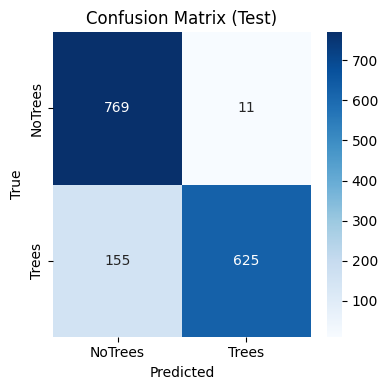

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# rebuild the model and load weights
ckpt = torch.load(BEST_PATH, map_location=DEVICE)

loaded_model = DeforNet(
    num_classes=len(ckpt["class_to_idx"]),
    channels=ckpt.get("channels", (32,64,128,256)),
    feature_dropout=FEATURE_DROPOUT,
    classifier_dropout=CLASSIFIER_DROPOUT
).to(DEVICE)
loaded_model.load_state_dict(ckpt["state_dict"])
loaded_model.eval()

@torch.no_grad()
def eval_epoch_model(model, loader, device):
    import torch.nn.functional as F
    total_loss, correct, total = 0.0, 0, 0
    all_labels, all_preds = [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = F.cross_entropy(logits, labels)
        total_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
        all_labels.extend(labels.cpu().tolist())
        all_preds .extend(preds.cpu().tolist())
    return total_loss/total, correct/total, all_labels, all_preds

test_loss, test_acc, test_labels, test_preds = eval_epoch_model(loaded_model, test_loader, DEVICE)
print(f"Test loss {test_loss:.4f}  acc {test_acc:.4f}")

print("\nClassification report (test):")
print(classification_report(
    test_labels, test_preds,
    target_names=[idx_to_class[i] for i in range(len(idx_to_class))],
    digits=4
))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=[idx_to_class[i] for i in range(len(idx_to_class))],
            yticklabels=[idx_to_class[i] for i in range(len(idx_to_class))],
            cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Test)")
plt.tight_layout(); plt.show()